#1 - Image Classification Task
1. Train 2 different models and get results.
Download the image classification data.
    - Train a classification model (using PyTorch or Tensorflow) to classify the tissue images into organ systems they come from. (Do not use a pre-trained model. You should create a model and a dataloader from scratch.)
    - Train a classification model (using Pytorch or Tensorflow) to classify the tissue images into organ systems they come from. Use a pre-trained model such as VGG, Inception, Efficientnet etc. You may use in-built functions to create your model and dataloader.
    - Calculate the training and test accuracy of your model. 
2. Visualize 
    - Overlap between training and test datasets in 2D, e.g., using t-SNE, UMAP, MDS etc.
    - Prediction results


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing the libraries and dependencies and drive
The following cell block imports all the libraries, functions, methods that are being used inn this jupyter notebook.<br>
The Deep Learning/Machine Learning Libarary being used here is the high level keras API of tensorflow 2.X.<Br>
And the plotting is done with matplotlib or seaborn plotting packages.

Along with this all the constants that will be common throughout the file are defined and declared here.

In [ ]:
!pip install tensorflow_io

In [ ]:
!nvidia-smi

Sun Dec 19 03:06:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pandas as pd
from PIL import Image, ImageDraw
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import seaborn as sns
from keras.callbacks import CSVLogger
import tensorflow_datasets as tfds
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import random, cv2, os, cv2, gc, json
# import tensorflow_io as tfio
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

EPOCHS = 50
BATCH_SIZE = 16
CLASSES = 12
IMG_DIM = (3000, 3000, 3)
NEW_IMG_SIZE = (512, 512, 3)
SHUFFLE = False
NUM_LAYERS = 5
ACCURACY_THRESHOLD = 0.98
LEARNING_RATE = 0.001
SEED = 1
TRAIN = True

## Loading Data
The following block of code loads data in two formats.
- First is use the most common way - manually through numpy array.
- Second is the TFDS - Tensorflow dataset module which loads data in the format of tenorflow_dataset whic makes it fast o process and load data onto and away from the memory(GPU/CPU)

I experimented with both the above techniques but the second one was very fast and thats what i am sticking with.
As it loads the next batch of data onto GPU memory while the current batch is being operated on - this is done with the prefetching functionality of the tensirflow_dataset module.

In [5]:
path_train = "/content/drive/MyDrive/datas/Data/Image Classification Data/data/train/"
path_test = "/content/drive/MyDrive/datas/Data/Image Classification Data/data/test/"
classes = os.listdir('/content/drive/MyDrive/datas/Data/Image Classification Data/data/train')

In [ ]:
train_df = pd.DataFrame({"images":[],"labels":[]})
for cls in classes:
    images = os.listdir(path_train+cls)
    for img in range(len(images)):
        image = np.array(Image.open(path_train + cls + "/" + images[img]))
        images[img] = cv2.resize(image, (512,512)).astype(np.int16)
        del image
    temp = pd.DataFrame({"images":images,"labels":[cls]*(len(images))})
    del images
    train_df = pd.concat([train_df, temp])
    del temp
    gc.collect()

train_df.shape

In [ ]:
test_df = pd.DataFrame({"images":[],"labels":[]})
for cls in classes:
    images = os.listdir(path_test+cls)
    for img in range(len(images)):
        image = np.array(Image.open(path_test + cls + "/" + images[img]))
        images[img] = cv2.resize(image, (512,512)).astype(np.int16)
        del image
    temp = pd.DataFrame({"images":images,"labels":[cls]*(len(images))})
    del images
    test_df = pd.concat([test_df, temp])
    del temp
    gc.collect()

test_df.shape

In [3]:
train_images = np.load("/content/drive/MyDrive/datas/train_images.npy",allow_pickle=True)
train_labels = np.load("/content/drive/MyDrive/datas/train_labelss.npy",allow_pickle=True)
train_df = pd.DataFrame({"images":train_images, "labels":train_labels})

test_images = np.load("/content/drive/MyDrive/datas/test_images.npy",allow_pickle=True)
test_labels = np.load("/content/drive/MyDrive/datas/test_labels.npy",allow_pickle=True)
test_df = pd.DataFrame({"images":test_images, "labels":test_labels})

## Labels, preprocessing & Look at the data

In [6]:
classes_TO_labels = {cls:i for i,cls in enumerate(classes)}
labels_TO_classes = {y:x for x, y in classes_TO_labels.items()}
train_df['labels'] = train_df['labels'].replace(classes_TO_labels)
test_df['labels'] = test_df['labels'].replace(classes_TO_labels)
classes_TO_labels

{'colon': 10,
 'endometrium_1': 11,
 'endometrium_2': 8,
 'kidney': 5,
 'liver': 6,
 'lung': 2,
 'lymph_node': 7,
 'pancreas': 9,
 'skin_1': 3,
 'skin_2': 0,
 'small_intestine': 1,
 'spleen': 4}

In [39]:
def generator():
    for i in train_df.iterrows():
        # t = np.array(Image.open(i[1]['images']))
        # x = cv2.resize(t, (512,512))
        y = tf.one_hot(i[1]['labels'], depth=12)
        yield tf.cast(i[1]['images'], tf.float32)/255.0, tf.cast(y, tf.int8)


def generator_test():
    for i in test_df.iterrows():
        y = tf.one_hot(i[1]['labels'], depth=12)
        yield tf.cast(i[1]['images'], tf.float32)/255.0, tf.cast(y, tf.int8)

dataset = tf.data.Dataset.from_generator(generator, (tf.float32, tf.int8), output_shapes=((512,512,3), (12)))
dataset_test = tf.data.Dataset.from_generator(generator_test, (tf.float32, tf.int8), output_shapes=((512,512,3), (12)))

ds_train = dataset.cache()
ds_train = ds_train.shuffle(1200)
ds_train = ds_train.batch(BATCH_SIZE)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = dataset_test.batch(BATCH_SIZE)
# ds_test = ds_test.shuffle(600)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

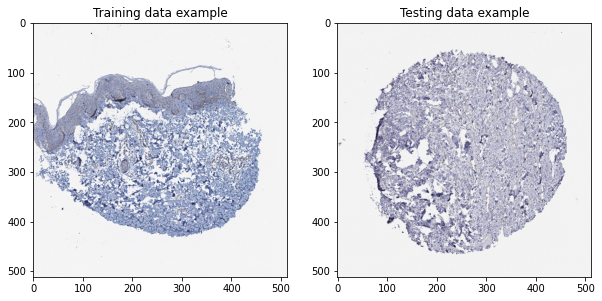

In [40]:
plt.figure(figsize = (10,10))
for i in ds_train.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(i[0][0])
    plt.title("Training data example")

for i in ds_test.take(1):
    plt.subplot(1, 2, 2)
    plt.imshow(i[0][0])
    plt.title("Testing data example")

## Model architecture & helper methods
There are three helper methods :-
- seed_everthing - sets the seed for numpy, tensorflow and random modules so that when we try and replicate a result we can do so if the seeds are same.
- clear_tf - clears the backend of the tensorflow module.
- Model - this method defines a common method which will be used commonly accross to define a Deep Learning model.

In [41]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% validation accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

checkpoint = keras.callbacks.ModelCheckpoint('', monitor='accuracy', mode='max', verbose=1, save_best_only=True)

In [42]:
def seed_everything(n):
    np.random.seed(n)
    tf.compat.v1.random.set_random_seed(n)
    random.seed(n)

def clear_tf():
    tf.keras.backend.clear_session()

def Model(inp_size = IMG_DIM,
          layers = NUM_LAYERS, 
          layers_nodes = [4, 8, 16, 8, 4], 
          dropout_include = False, 
          max_pooling_num = 2,
          strides = 2, 
          kernel_size = 3,
          classes = CLASSES, 
          dropout_ratio = [0.2]*NUM_LAYERS,
          activation_fn = keras.layers.LeakyReLU(),
          initializer = 'glorot_uniform',    # Default value
          loss_fn = "categorical_crossentropy",#tf.keras.losses.SparseCategoricalCrossentropy(),
          optimizer = keras.optimizers.Adam(learning_rate=0.0001), 
          include_normalization = True):
    
    assert layers == len(layers_nodes), "Layer size and number of nodes for each layer are not equal"
    assert layers == len(dropout_ratio), "Dropout array size and number of layers do not match"

    inp = tf.keras.layers.Input(shape = inp_size)
    # layer_x = tf.keras.layers.Flatten()(inp)
    layer_x = tf.keras.layers.Conv2D(layers_nodes[0], strides = strides, kernel_size = kernel_size, 
                                 activation = activation_fn,
                                 kernel_initializer = initializer,
                                 name = 'Conv2D_Layer_1')(inp)
    # layer_x = tf.keras.layers.MaxPooling2D(max_pooling_num)(layer_x)
    if include_normalization:
        layer_x = tf.keras.layers.BatchNormalization()(layer_x)

    if dropout_include:
        layer_x = tf.keras.layers.Dropout(dropout_ratio[0])(layer_x)

    for layer_num in range(1, layers):
        layer_x = tf.keras.layers.Conv2D(layers_nodes[layer_num], strides = strides, kernel_size = kernel_size,  
                                     activation = activation_fn,
                                     kernel_initializer = initializer,
                                     name = 'Conv2D_Layer_'+str(layer_num+1))(layer_x)
        # layer_x = tf.keras.layers.MaxPooling2D(max_pooling_num)(layer_x)
        if include_normalization:
            layer_x = tf.keras.layers.BatchNormalization()(layer_x)
        if dropout_include:
            layer_x = tf.keras.layers.Dropout(dropout_ratio[layer_num])(layer_x)
    
    layer_x = tf.keras.layers.Flatten()(layer_x)
    out = tf.keras.layers.Dense(classes, activation = "softmax", name = "Output")(layer_x)

    model = tf.keras.models.Model(inputs = inp, outputs = out)
    model.compile(loss = loss_fn, 
                  optimizer = optimizer, 
                  metrics = ['accuracy'])
    
    return model

clear_tf()
seed_everything(SEED)
Model(inp_size=(512,512,3)).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 Conv2D_Layer_1 (Conv2D)     (None, 255, 255, 4)       112       
                                                                 
 batch_normalization (BatchN  (None, 255, 255, 4)      16        
 ormalization)                                                   
                                                                 
 Conv2D_Layer_2 (Conv2D)     (None, 127, 127, 8)       296       
                                                                 
 batch_normalization_1 (Batc  (None, 127, 127, 8)      32        
 hNormalization)                                                 
                                                                 
 Conv2D_Layer_3 (Conv2D)     (None, 63, 63, 16)        1168  

## Custom data loader & generator

In [ ]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, dataset, labels, 
                 batch_size = BATCH_SIZE, 
                 dim = (256,256,3),#NEW_IMG_SIZE, 
                 n_classes = CLASSES, 
                 shuffle = SHUFFLE):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.dataset = dataset
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.list_IDs = np.arange(self.dataset.shape[0])
        self.indexes = np.arange(len(self.list_IDs))
        # self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(self.dataset.shape[0] / self.batch_size))

    def __getitem__(self, index):

        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            im = np.array(Image.open(self.dataset[ID]))
            X[i,] = cv2.resize(im, (256,256))
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

train_generator = DataGenerator(train_df['images'].values, 
                                train_df['labels'].values)
val_generator = DataGenerator(test_df['images'].values, 
                              test_df['labels'].values)

In [ ]:
# checkpoint1 = keras.callbacks.ModelCheckpoint('content/drive/checkpoint.h5', monitor='loss', mode='min', verbose=1, save_best_only=True)
# logger = CSVLogger('content/drive/logs.log', separator=',', append=False)

model = Model(inp_size=(512, 512, 3))
model.fit(train_generator,
            validation_data=val_generator,
            use_multiprocessing=True, 
            epochs=EPOCHS,)

Epoch 1/20
150/150 [==============================] - 1673s 11s/step - loss: 3.2451 - accuracy: 0.0983 - val_loss: 2.9240 - val_accuracy: 0.1333
Epoch 2/20
150/150 [==============================] - 2813s 19s/step - loss: 2.8484 - accuracy: 0.1142 - val_loss: 2.5242 - val_accuracy: 0.1583
Epoch 3/20
150/150 [==============================] - 2823s 19s/step - loss: 2.5317 - accuracy: 0.1633 - val_loss: 2.3660 - val_accuracy: 0.1717
Epoch 4/20
150/150 [==============================] - 2508s 17s/step - loss: 2.3357 - accuracy: 0.1992 - val_loss: 2.2654 - val_accuracy: 0.2300
Epoch 5/20
150/150 [==============================] - 2482s 17s/step - loss: 2.1284 - accuracy: 0.2483 - val_loss: 2.2415 - val_accuracy: 0.2367
Epoch 6/20
 48/150 [========>.....................] - ETA: 16:10 - loss: 1.9416 - accuracy: 0.3333

KeyboardInterrupt: ignored

Note:- Unfortunately due to the huge image size/resolution the training of the model with custom data loader was taking around 35 minutes per epoch so i switched gears to a custom tfds data generator.

In [ ]:
clear_tf()
model = Model(inp_size=(512, 512, 3))
model.fit(ds_train,
            validation_data=ds_test,
            # use_multiprocessing=True, 
            epochs=EPOCHS,)

Epoch 1/50
75/75 [==============================] - 3s 36ms/step - loss: 3.0955 - accuracy: 0.1017 - val_loss: 3.1939 - val_accuracy: 0.0933
Epoch 2/50
75/75 [==============================] - 2s 32ms/step - loss: 2.6254 - accuracy: 0.1675 - val_loss: 3.0042 - val_accuracy: 0.1100
Epoch 3/50
75/75 [==============================] - 2s 32ms/step - loss: 2.3560 - accuracy: 0.2117 - val_loss: 2.5629 - val_accuracy: 0.1700
Epoch 4/50
75/75 [==============================] - 2s 32ms/step - loss: 2.1891 - accuracy: 0.2542 - val_loss: 2.3464 - val_accuracy: 0.2017
Epoch 5/50
75/75 [==============================] - 2s 32ms/step - loss: 2.0710 - accuracy: 0.2975 - val_loss: 2.2321 - val_accuracy: 0.2000
Epoch 6/50
75/75 [==============================] - 2s 32ms/step - loss: 1.9896 - accuracy: 0.3200 - val_loss: 2.1560 - val_accuracy: 0.2267
Epoch 7/50
75/75 [==============================] - 2s 32ms/step - loss: 1.8979 - accuracy: 0.3500 - val_loss: 2.1214 - val_accuracy: 0.2317
Epoch 8/50
75

## Save and load the model

In [ ]:
if TRAIN:
    model.save('/content/drive/MyDrive/datas/my_model.h5')
else:
    model = tf.keras.models.load_model('/content/drive/MyDrive/datas/my_model.h5')
model.evaluate(ds_test)

38/38 [==============================] - 1s 17ms/step - loss: 2.0991 - accuracy: 0.3700


[2.0991361141204834, 0.3700000047683716]

## Model structure

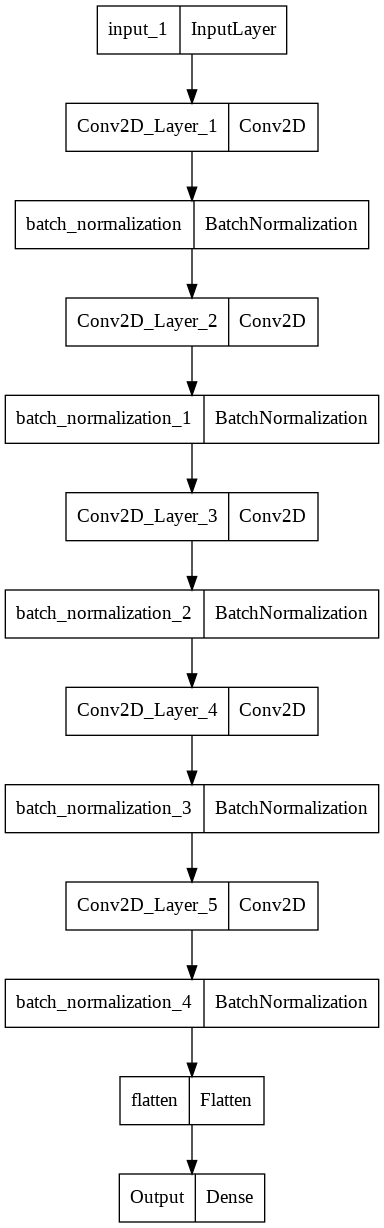

In [ ]:
tf.keras.utils.plot_model(model)

## Accuracy and Loss plot for custom model

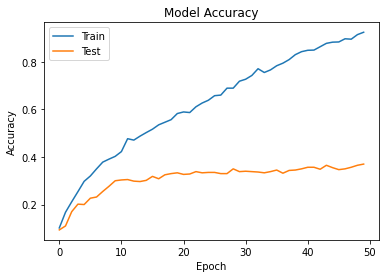

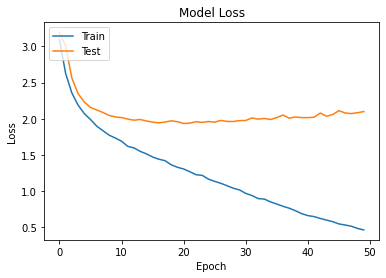

In [ ]:
# summarize history for accuracy
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Pretrained VGG

In [44]:
ACCURACY_THRESHOLD = 1
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        # print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        if(logs.get('accuracy') == ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% training accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

# checkpoint = keras.callbacks.ModelCheckpoint('', monitor='accuracy', mode='max', verbose=1, save_best_only=True)

In [45]:
vgg = tf.keras.applications.VGG16(include_top=False,
                                        weights='imagenet',)
inp = tf.keras.layers.Input(shape = NEW_IMG_SIZE)
layer = tf.keras.layers.MaxPool2D(2)(inp)
layer = vgg(layer)
layer = tf.keras.layers.Flatten()(layer)
layer = tf.keras.layers.Dense(1024, activation=tf.keras.layers.LeakyReLU())(layer)
output = tf.keras.layers.Dense(12, activation = 'softmax')(layer)

my_vgg = tf.keras.models.Model(inputs = inp, outputs = output)
my_vgg.compile(loss = 'categorical_crossentropy', 
                  optimizer = tf.keras.optimizers.Adam(0.00001), 
                  metrics = ['accuracy'])
my_vgg.fit(ds_train, 
               validation_data = ds_test,
               epochs = EPOCHS, 
             callbacks = [CustomCallback()])

58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/50
      6/Unknown - 5s 153ms/step - loss: 2.4138 - accuracy: 0.1667WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0620s vs `on_train_batch_end` time: 0.0761s). Check your callbacks.
75/75 [==============================] - 18s 188ms/step - loss: 1.5419 - accuracy: 0.4750 - val_loss: 0.9790 - val_accuracy: 0.6217
Epoch 2/50
75/75 [==============================] - 13s 169ms/step - loss: 0.5386 - accuracy: 0.8250 - val_loss: 0.7757 - val_accuracy: 0.7283
Epoch 3/50
75/75 [==============================] - 13s 171ms/step - loss: 0.2112 - accuracy: 0.9458 - val_loss: 0.7972 - val_accuracy: 0.7267
Epoch 4/50
75/75 [==============================] - 13s 171ms/step - loss: 0.0890 - accuracy: 0.9750 - val_loss: 0.7918 - val_accuracy: 0.7550
Epoch 5/50
75/75 [==============================] - 13s 169ms/step - loss: 0.0776 - accuracy: 0.9783 - val_loss: 0.9040 - va

## Test accuracy & Model weights

In [46]:
if TRAIN:
    my_vgg.save('/content/drive/MyDrive/datas/my_vgg.h5')
else:
    my_vgg = tf.keras.models.load_model('/content/drive/MyDrive/datas/my_vgg.h5')
my_vgg.evaluate(ds_test)

38/38 [==============================] - 2s 49ms/step - loss: 0.8846 - accuracy: 0.7700


[0.884645402431488, 0.7699999809265137]

## Visualization

### Results prediction for custom model

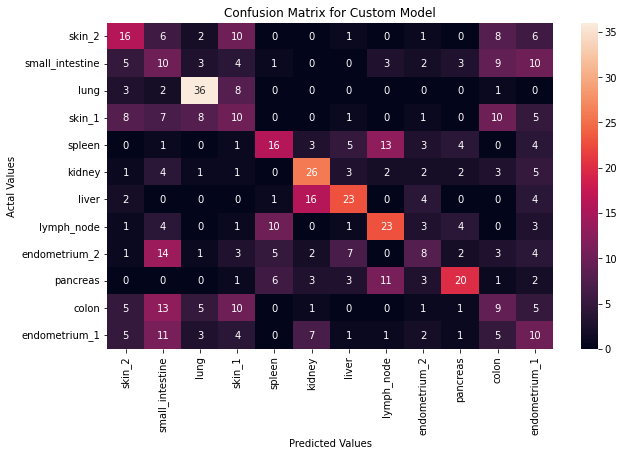

In [61]:
matrix = confusion_matrix(test_df.labels, np.argmax(model.predict(ds_test), axis=1))
cm_df = pd.DataFrame(matrix,
                     index = [labels_TO_classes[i] for i in range(0,12)], 
                     columns = [labels_TO_classes[i] for i in range(0,12)])
plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix for Custom Model')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### Results prediction for VGG model

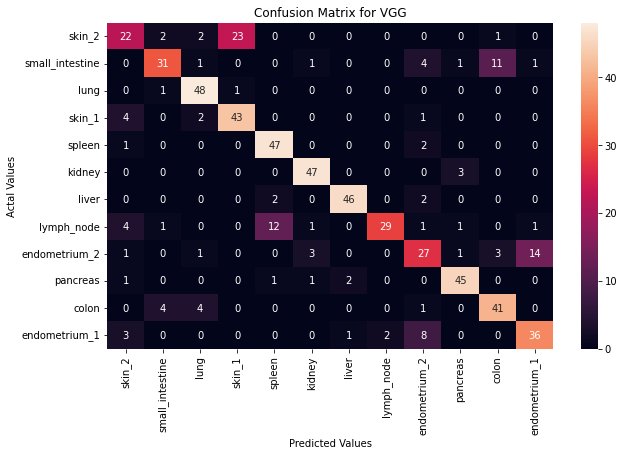

In [62]:
matrix = confusion_matrix(test_df.labels, np.argmax(my_vgg.predict(ds_test), axis=1))
cm_df = pd.DataFrame(matrix,
                     index = [labels_TO_classes[i] for i in range(0,12)], 
                     columns = [labels_TO_classes[i] for i in range(0,12)])
plt.figure(figsize=(10,6))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix for VGG')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

### Similarity between training and test datasets

In [9]:
tsne = TSNE(n_components=2, verbose=0, 
            perplexity=40, n_iter=500, learning_rate=100)
train_tsne_results = tsne.fit_transform(np.stack([img.flatten() for img in train_df.images.values]))
test_tsne_results = tsne.fit_transform(np.stack([img.flatten() for img in test_df.images.values]))

In [26]:
train_df = pd.DataFrame({"images":[],"labels":[]})
test_df = pd.DataFrame({"images":[],"labels":[],"most_similar_to":[]})

for cls in classes:
    images_test = os.listdir(path_test+cls)
    images_train = os.listdir(path_train+cls)

    most_similar_to = [np.nan]*(len(images_test))
    temp_train = pd.DataFrame({"images":images_train,"labels":[cls]*(len(images_train))})
    temp_test = pd.DataFrame({"images":images_test,"labels":[cls]*(len(images_test)), "most_similar_to":most_similar_to})

    test_df = pd.concat([test_df, temp_test])
    train_df = pd.concat([train_df, temp_train])

In [28]:
similar_to = []
for i in range(600):
    cos = cosine_similarity(train_tsne_results, np.expand_dims(test_tsne_results[i], axis=0))
    idx = np.argmax(cos)
    similar_to.append(train_df.images.values[idx])

test_df['most_similar_to'] = similar_to

In [29]:
test_df.head()

images  labels         most_similar_to
0  40199_166606_B_5_8.tif  skin_2   40134_97237_A_5_2.tif
1   40229_88854_B_6_8.tif  skin_2   40044_96798_A_7_4.tif
2  40182_140480_B_5_8.tif  skin_2   40071_95769_A_8_8.tif
3   40170_89105_B_5_8.tif  skin_2  40066_141607_B_2_3.tif
4  40182_140480_B_6_8.tif  skin_2   40118_84737_B_8_4.tif

## Model output and internal working understanding

In [91]:
def visualize_layer_PCA(layer_name, data, labels, mod):#, ax):
    layer_output = mod.get_layer(layer_name).output

    intermediate_model = tf.keras.models.Model(inputs = mod.input,
                                               outputs = layer_output)
    
    intermediate_prediction = intermediate_model.predict(data) # tf.cast(data, tf.float32)/255.0

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(np.stack([img.flatten() for img in intermediate_prediction]))

    plt.subplot(1, 2, 1)
    sns.scatterplot(
        x = pca_result[:,0], 
        y = pca_result[:,1],
        hue=labels,
        palette = sns.color_palette("hls", 12),
        legend = "full",
        alpha = 0.3)#, ax = ax)
    plt.title(f"PCA for layer {layer_name}")
    plt.xlabel("PCA 1st Component")
    plt.ylabel("PCA 2nd Component")
    for i in range(10):
        xtext, ytext = np.median(pca_result[labels == i, :], axis=0)
        plt.text(xtext, ytext, labels_TO_classes[i], fontsize=12)
    

In [102]:
def visualize_layer_TSNE(layer_name, data, labels, mod,):# ax):
    layer_output = mod.get_layer(layer_name).output

    intermediate_model = tf.keras.models.Model(inputs = mod.input,
                                               outputs = layer_output)
    intermediate_prediction = intermediate_model.predict(data)

    tsne = TSNE(n_components=2, verbose=0, perplexity=20, n_iter=500)
    tsne_results = tsne.fit_transform(np.stack([img.flatten() for img in intermediate_prediction]))

    # plt.figure(figsize=(10,6))
    plt.subplot(1, 2, 2)
    sns.scatterplot(
        x = tsne_results[:,0], 
        y = tsne_results[:,1],
        hue=labels,
        palette=sns.color_palette("hls", 12),
        legend="full",
        alpha=0.3,)
        # ax = ax)
    plt.title(f"TSNE for layer {layer_name}")
    plt.xlabel("TSNE 1st Component")
    plt.ylabel("TSNE 2nd Component")
    for i in range(10):
        xtext, ytext = np.median(tsne_results[labels == i, :], axis=0)
        plt.text(xtext, ytext, labels_TO_classes[i], fontsize=12)
    # plt.show()

### TSNE on train set and output for train set images

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 1.255s...
[t-SNE] Computed neighbors for 1200 samples in 70.553s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 8817.663640
[t-SNE] KL divergence after 250 iterations with early exaggeration: 105.686523
[t-SNE] KL divergence after 500 iterations: 1.562698


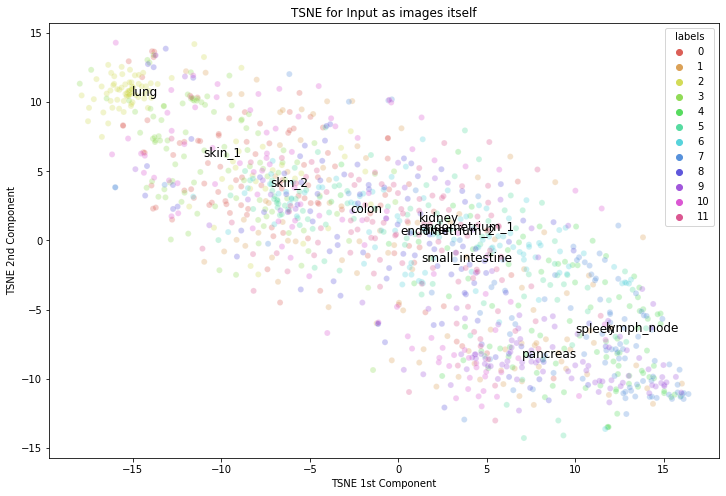

In [65]:
tsne_inp = train_df.images.values

tsne = TSNE(n_components=2, verbose=1, 
            perplexity=40, n_iter=500)
tsne_results = tsne.fit_transform(np.stack([img.flatten() for img in tsne_inp]))

plt.figure(figsize=(12,8))
sns.scatterplot(
            x = tsne_results[:,0], 
            y = tsne_results[:,1],
            hue=train_df['labels'],
            palette=sns.color_palette("hls", 12),
            legend="full",
            alpha=0.3
        )
plt.title("TSNE for Input as images itself")
plt.xlabel("TSNE 1st Component")
plt.ylabel("TSNE 2nd Component")

for idx in range(12):
    xtext, ytext = np.median(tsne_results[train_df['labels'] == idx, :], axis=0)
    plt.text(xtext, ytext, labels_TO_classes[idx], fontsize=12)

plt.show()

PCA & T-SNE for layer :  Conv2D_Layer_1


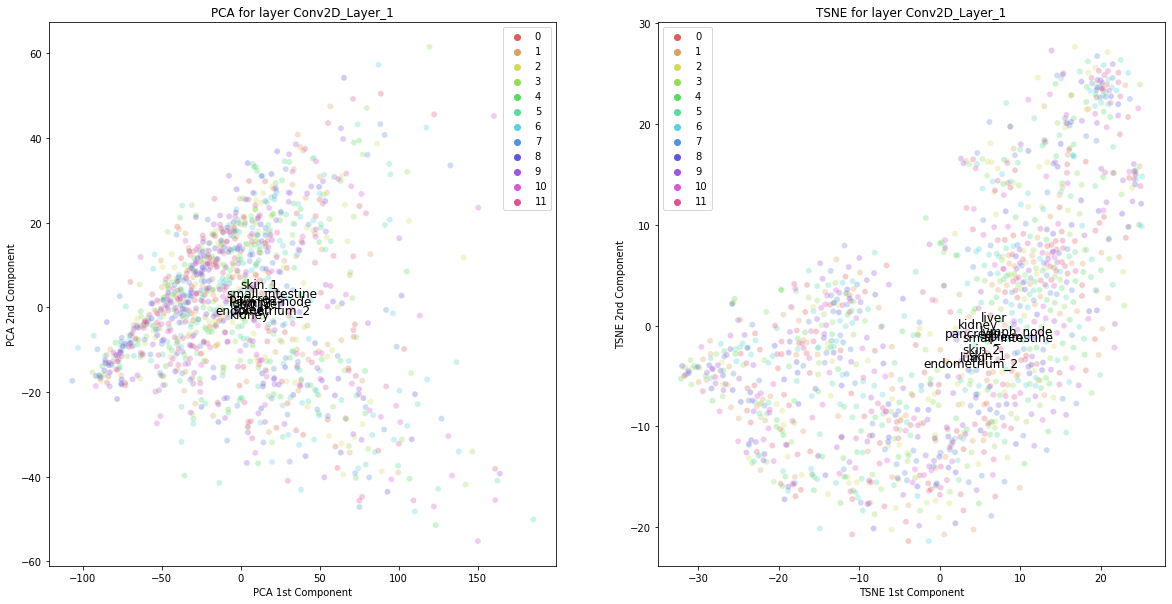

PCA & T-SNE for layer :  Conv2D_Layer_2


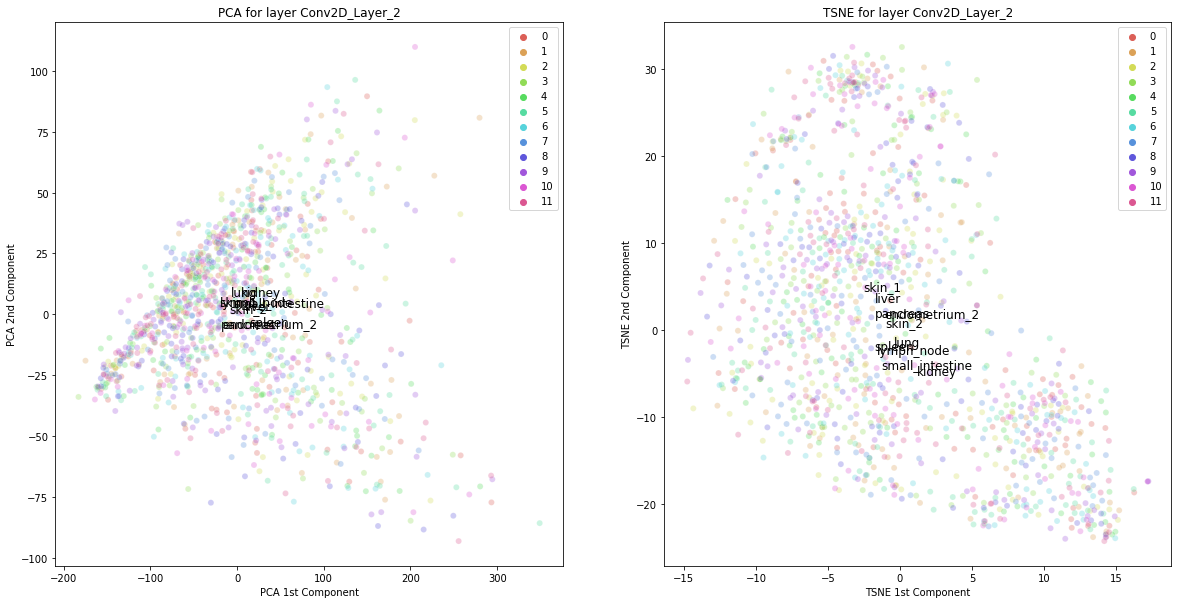

PCA & T-SNE for layer :  Conv2D_Layer_3


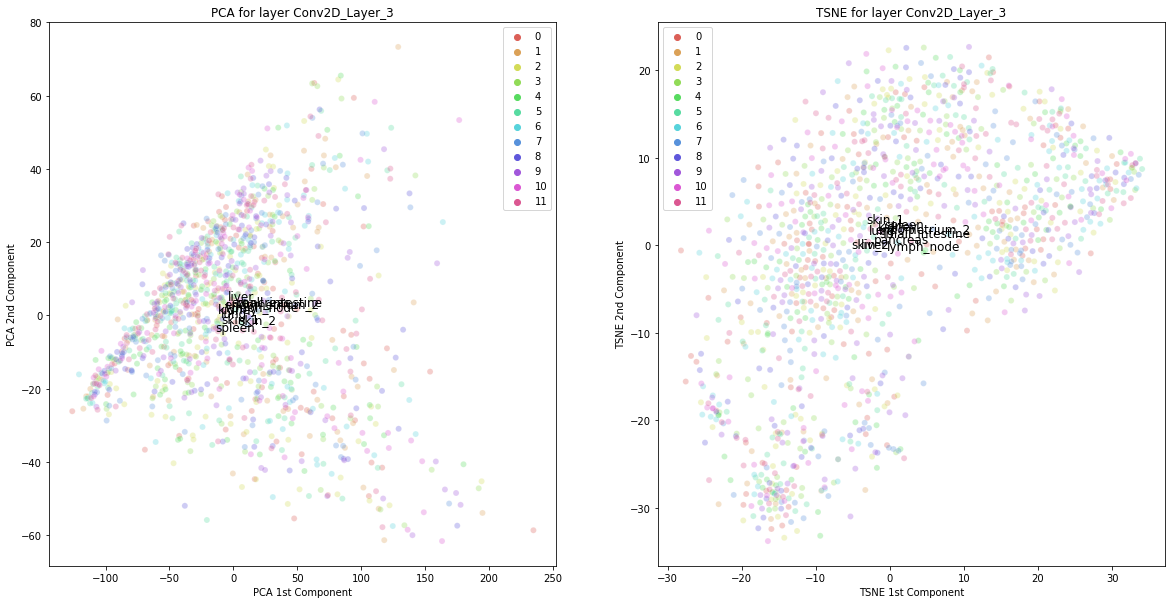

PCA & T-SNE for layer :  Conv2D_Layer_4


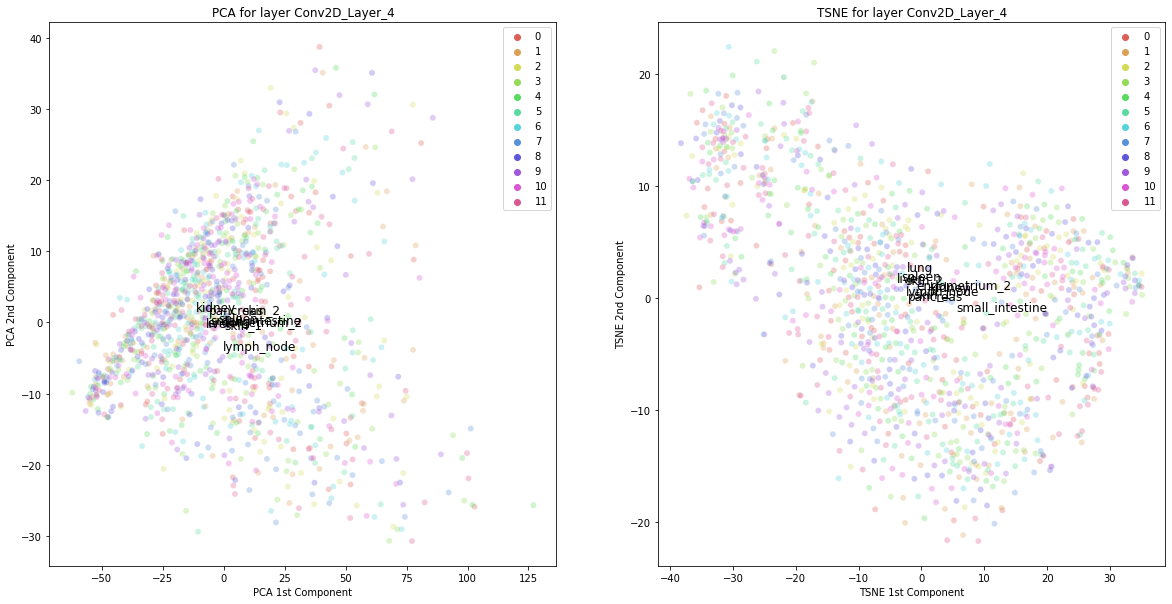

PCA & T-SNE for layer :  Conv2D_Layer_5


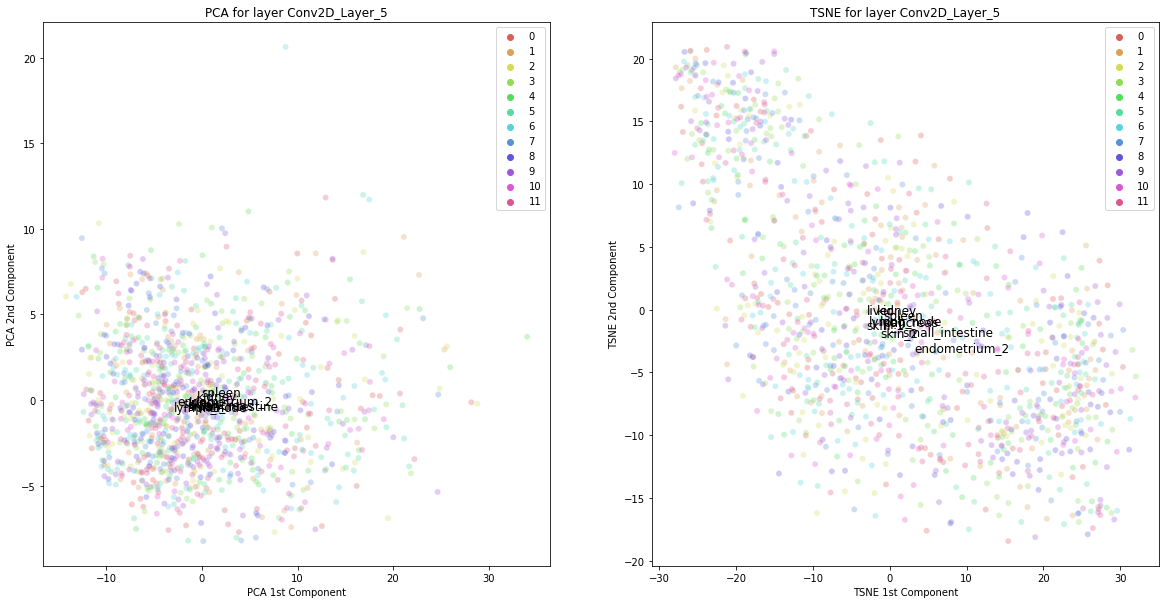

In [103]:
for layer in model.layers:
    name = layer.name
    if 'Conv2D' in name: 
        print("PCA & T-SNE for layer : ", name)
        plt.figure(figsize=(20,10))
        visualize_layer_PCA(name, ds_train, train_df.labels.values, model)
        visualize_layer_TSNE(name, ds_train, train_df.labels.values, model)
        plt.show()

### TSNE on test set and output for test set images

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 600 samples in 0.486s...
[t-SNE] Computed neighbors for 600 samples in 23.169s...
[t-SNE] Computed conditional probabilities for sample 600 / 600
[t-SNE] Mean sigma: 10352.059849
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.249748
[t-SNE] KL divergence after 500 iterations: 1.164943


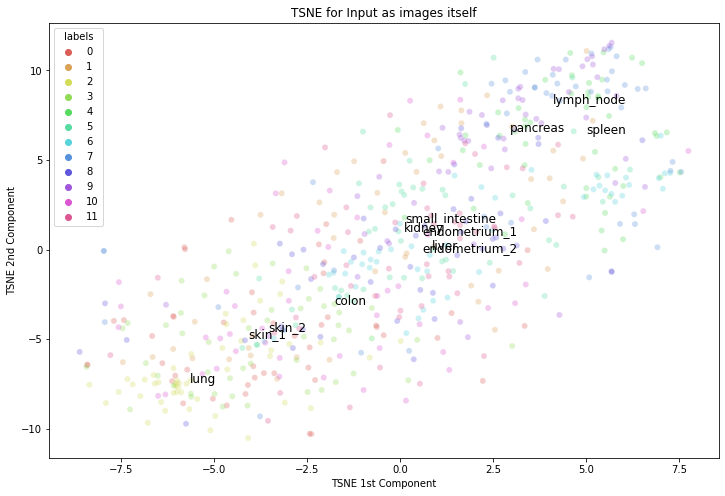

In [73]:
tsne_inp = test_df.images.values

tsne = TSNE(n_components=2, verbose=1, 
            perplexity=40, n_iter=500, learning_rate=100)
tsne_results = tsne.fit_transform(np.stack([img.flatten() for img in tsne_inp]))

plt.figure(figsize=(12,8))
sns.scatterplot(
            x = tsne_results[:,0], 
            y = tsne_results[:,1],
            hue=test_df['labels'],
            palette=sns.color_palette("hls", 12),
            legend="full",
            alpha=0.3
        )
plt.title("TSNE for Input as images itself")
plt.xlabel("TSNE 1st Component")
plt.ylabel("TSNE 2nd Component")

for idx in range(12):
    xtext, ytext = np.median(tsne_results[test_df['labels'] == idx, :], axis=0)
    plt.text(xtext, ytext, labels_TO_classes[idx], fontsize=12)

plt.show()

PCA & T-SNE for layer :  Conv2D_Layer_1


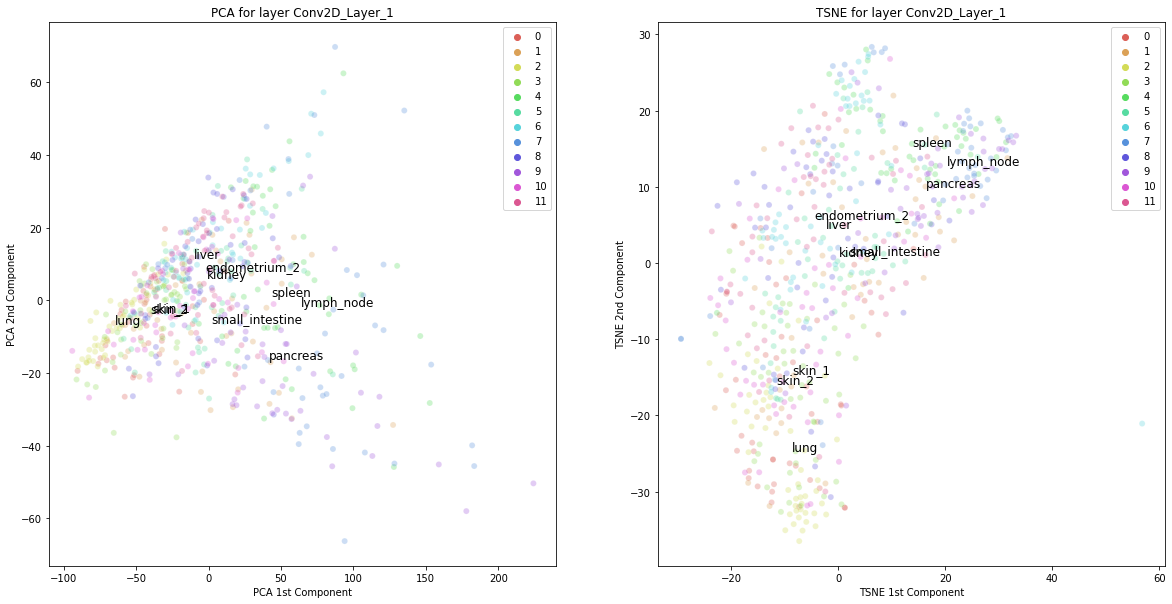

PCA & T-SNE for layer :  Conv2D_Layer_2


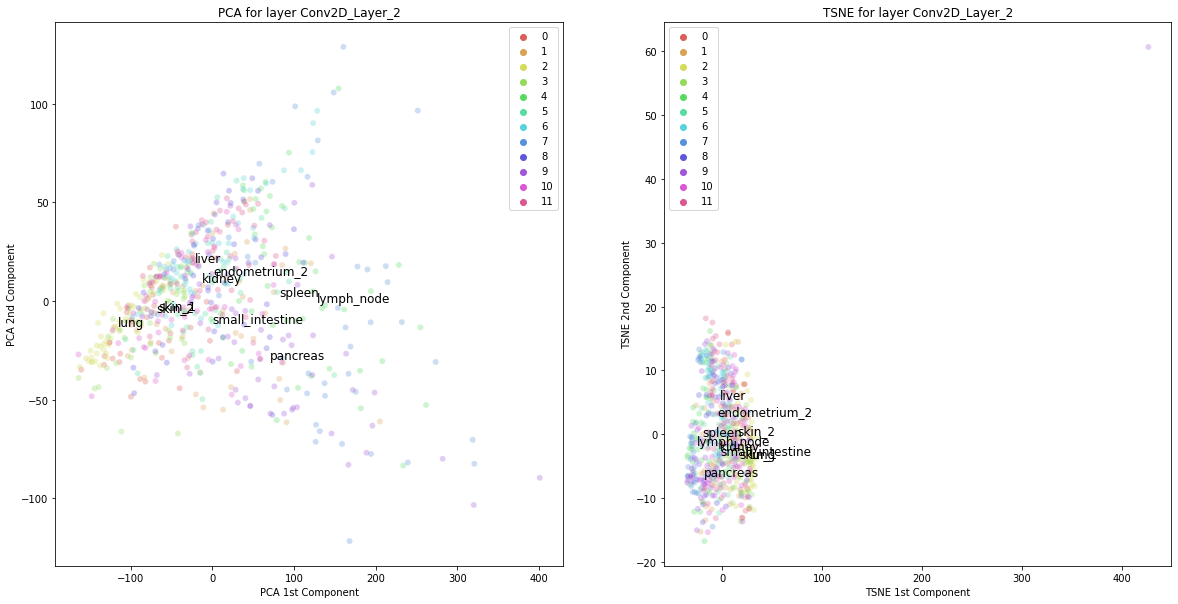

PCA & T-SNE for layer :  Conv2D_Layer_3


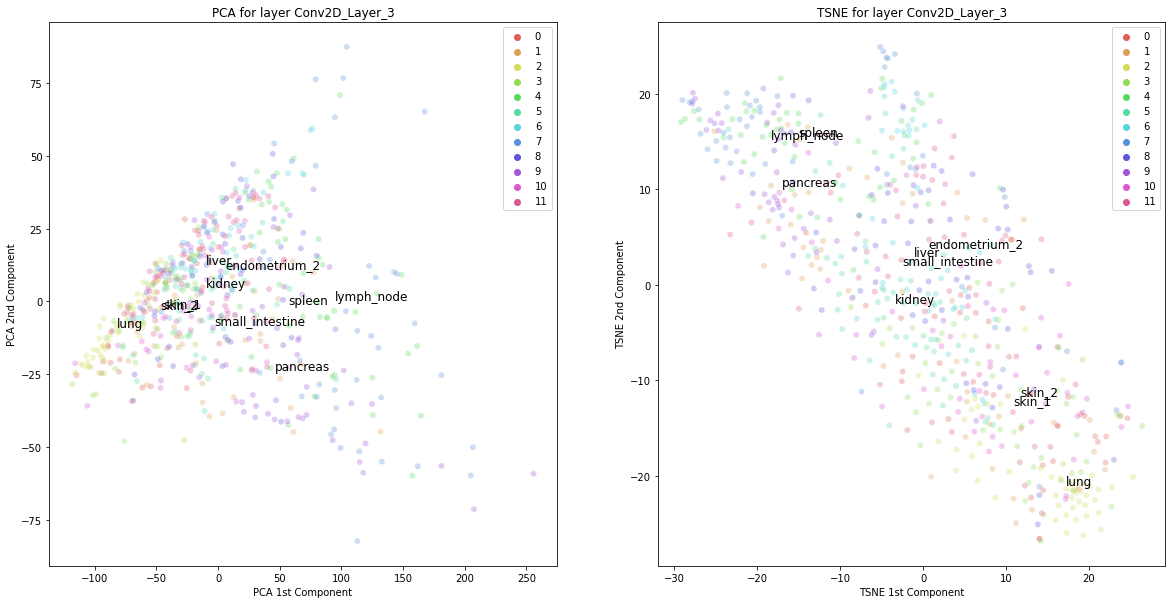

PCA & T-SNE for layer :  Conv2D_Layer_4


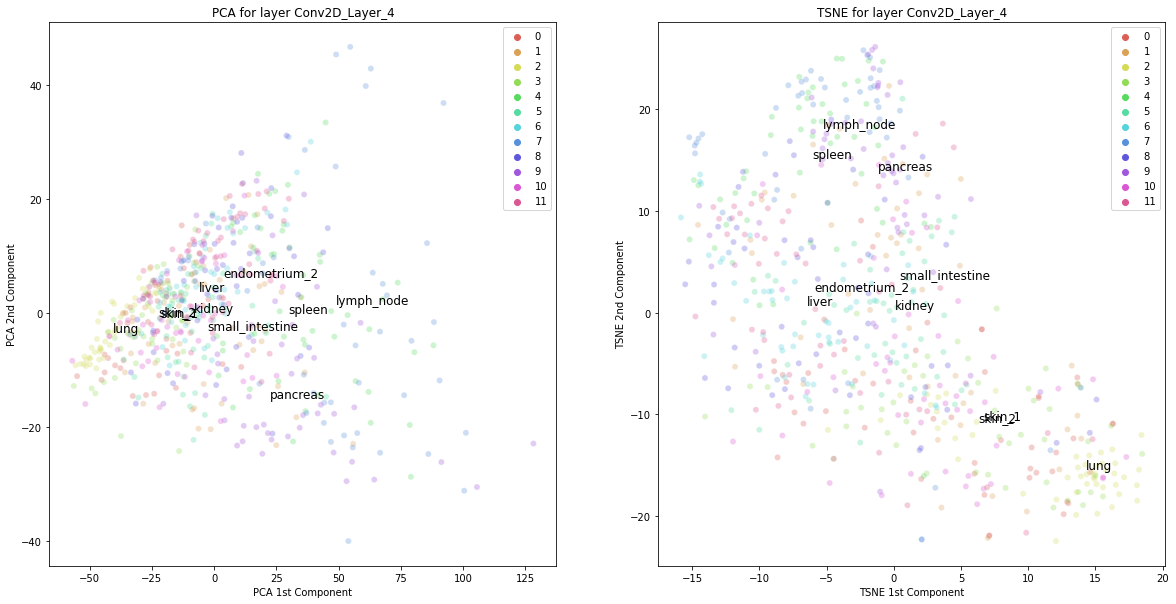

PCA & T-SNE for layer :  Conv2D_Layer_5


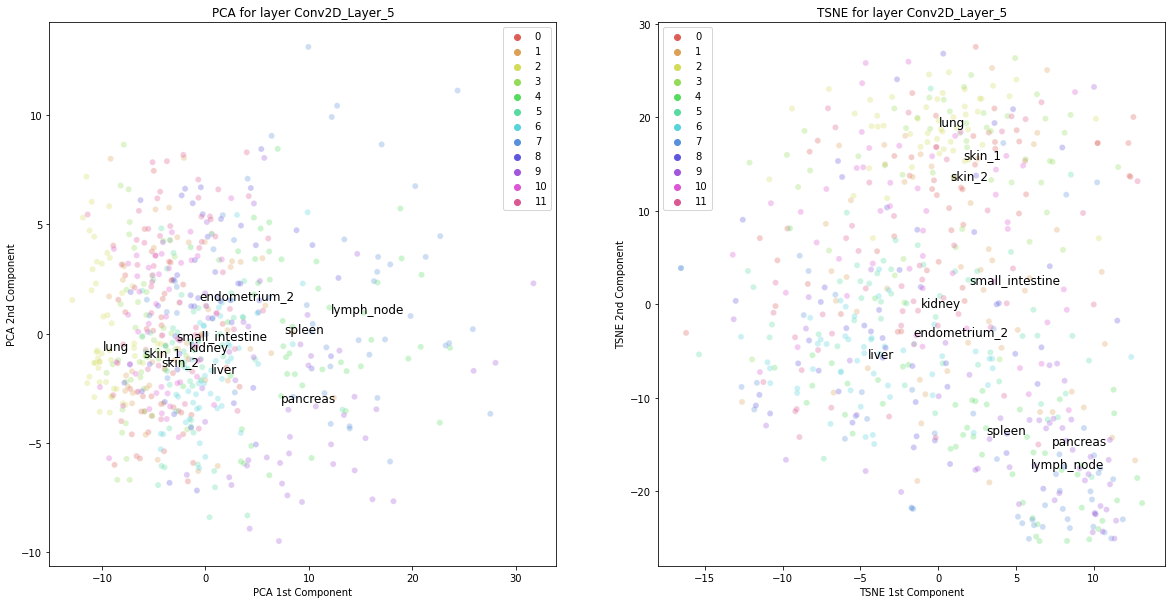

In [94]:
for layer in model.layers:
    name = layer.name
    if 'Conv2D' in name: 
        print("PCA & T-SNE for layer : ", name)
        plt.figure(figsize=(20,10))
        visualize_layer_PCA(name, ds_test, test_df.labels.values, model)
        visualize_layer_TSNE(name, ds_test, test_df.labels.values, model)
        plt.show()

# Segmentation
Only did this for some brownie points.

Some points:-
- The image size was too large that the custom model that i built went out of memory to allocate the weights of the model for even a single image - so had to reduce the size of the imgaes a lot
- Due to some pecularities i wasnt able to get any output as masks so did some changes to the input(cheating) like i added the annotated masks to the images to make the features which are to be masked stand out but even that didnt make any difference.

So some reasons why this happened can be:-
- Noise in the data which seems to be there (as can be seen from the black patches in the data)
- Less data - definitely the data was less but i tries overcoming this with data augmentation(didnt make any difference)
- The features to be masked are the least prominent in the image

In [ ]:
encodings_train = pd.read_csv("/content/drive/MyDrive/hiring_assignment/Colonic_crypt_dataset/train.csv")
encodings_train = encodings_train[encodings_train.id != "HandE_B005_CL_b_RGB_topright"]
encodings_test = pd.read_csv("/content/drive/MyDrive/hiring_assignment/Colonic_crypt_dataset/test.csv")
train_df = np.zeros(((5, 4536, 4704, 3)))
test_df = np.zeros(((2, 4536, 4704, 3)))

for idx,i in enumerate(encodings_train['id']):
    train_df[idx,:] = np.array(Image.open("/content/drive/MyDrive/hiring_assignment/Colonic_crypt_dataset/train/"+i+".tiff"))

for idx,i in enumerate(encodings_test['id']):
    test_df[idx,:] = np.array(Image.open("/content/drive/MyDrive/hiring_assignment/Colonic_crypt_dataset/test/"+i+".tiff"))

def rle2mask(mask_rle, shape): 
    '''
    mask_rle: run-length as string format (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

train_mask = np.zeros((5, 4536, 4704) )
test_mask = np.zeros((2, 4536, 4704) )

for idx,x in enumerate(encodings_train['predicted']):
    single_image_rle = x.split()
    train_mask[idx,:] = rle2mask(single_image_rle, (4704, 4536))

for idx,x in enumerate(encodings_test['predicted']):
    single_image_rle = x.split()
    test_mask[idx,:] = rle2mask(single_image_rle, (4704, 4536))

def UNet(n_classes=1, IMG_HEIGHT=4536, IMG_WIDTH=4704, IMG_CHANNELS=3):
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Encoder
    c1 = tf.keras.layers.Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.2)(c1)  
    c1 = tf.keras.layers.Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
    c2 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.2)(c2)  
    c2 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
     
    c3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
     
    c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
     
    # Transfer Block
    c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Decoder 
    u6 = tf.keras.layers.Conv2DTranspose(32, (3, 2), strides=(2, 2))(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.2)(c8)  
    c8 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = tf.keras.layers.Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.2)(c9)  
    c9 = tf.keras.layers.Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

UNet = UNet()
UNet.compile(optimizer='adam',
              loss='mse',
              metrics=['accuracy'])

UNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4536, 4704,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 4536, 4704,   112         ['input_1[0][0]']                
                                4)                                                                
                                                                                                  
 dropout (Dropout)              (None, 4536, 4704,   0           ['conv2d[0][0]']                 
                                4)                                                            

In [ ]:
UNet.fit(train_df, train_mask, validation_data=(test_df, test_mask), epochs=10)

Epoch 1/10


ResourceExhaustedError: ignored

In [35]:
encodings_train2 = pd.read_csv("/content/drive/MyDrive/hiring_assignment/Colonic_crypt_dataset/train.csv")
encodings_train2 = encodings_train2[encodings_train2.id != "HandE_B005_CL_b_RGB_topright"]
encodings_test2 = pd.read_csv("/content/drive/MyDrive/hiring_assignment/Colonic_crypt_dataset/test.csv")
train_df2 = np.zeros(((5, 512, 512, 3)), dtype = np.float32)
test_df2 = np.zeros(((2, 512, 512, 3)), dtype = np.float32)

for idx,i in enumerate(encodings_train2['id']):
    json_filename = "/content/drive/MyDrive/hiring_assignment/Colonic_crypt_dataset/train/"+i+'.json'
    read_file = open(json_filename, "r") 
    data = json.load(read_file)

    polys = []
    for index in range(data.__len__()):
        geom = np.array(data[index]['geometry']['coordinates'])
        polys.append(geom.astype(int))

    img = Image.open("/content/drive/MyDrive/hiring_assignment/Colonic_crypt_dataset/train/"+i+".tiff")
    for i in range(len(polys)):
        poly = polys[i]
        ImageDraw.Draw(img).polygon(tuple(map(tuple, poly[0])), outline=1, fill=1) 

    train_df2[idx,:] = cv2.resize(np.array(img), (512, 512)).astype(np.float32)/255.0

for idx,i in enumerate(encodings_test2['id']):
    json_filename = "/content/drive/MyDrive/hiring_assignment/Colonic_crypt_dataset/test/"+i+'.json'
    read_file = open(json_filename, "r") 
    data = json.load(read_file)

    polys = []
    for index in range(data.__len__()):
        geom = np.array(data[index]['geometry']['coordinates'])
        polys.append(geom.astype(int))

    img = Image.open("/content/drive/MyDrive/hiring_assignment/Colonic_crypt_dataset/test/"+i+".tiff")
    for i in range(len(polys)):
        poly = polys[i]
        ImageDraw.Draw(img).polygon(tuple(map(tuple, poly[0])), outline=1, fill=1) 

    test_df2[idx,:] = cv2.resize(np.array(img), (512, 512)).astype(np.float32)/255.0

In [42]:
def rle2mask(mask_rle, shape): 
    '''
    mask_rle: run-length as string format (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return cv2.resize(img.reshape(shape).T, (512, 512))

train_mask2 = np.zeros((5, 512, 512) )
test_mask2 = np.zeros((2, 512, 512) )

for idx,x in enumerate(encodings_train2['predicted']):
    single_image_rle = x.split()
    train_mask2[idx,:] = rle2mask(single_image_rle, (4704, 4536))

for idx,x in enumerate(encodings_test2['predicted']):
    single_image_rle = x.split()
    test_mask2[idx,:] = rle2mask(single_image_rle, (4704, 4536))

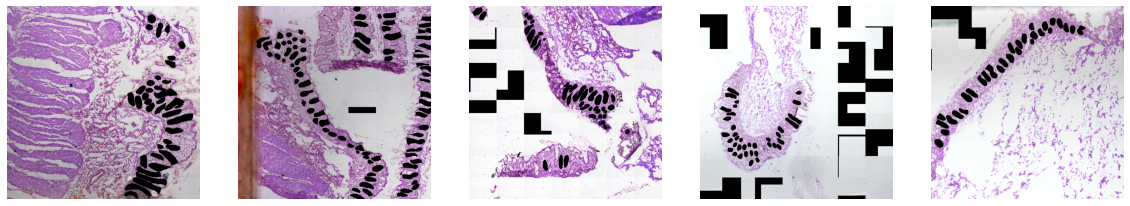

In [37]:
plt.figure(figsize=(20,20))
for idx, i in enumerate(train_df2):
    plt.subplot(1, 5, idx+1)
    plt.imshow(i)
    plt.axis("off")

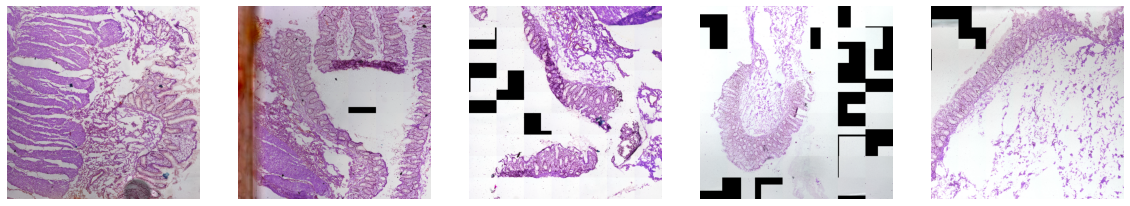

In [ ]:
plt.figure(figsize=(20,20))
for idx, i in enumerate(train_df2):
    plt.subplot(1, 5, idx+1)
    plt.imshow(i)
    plt.axis("off")

In [38]:
!pip install git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-vtae2qrb
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-vtae2qrb
  Created wheel for tensorflow-examples: filename=tensorflow_examples-6a5c4df82b032e1ee1e5095e6f9baeb732b294db_-py3-none-any.whl size=268414 sha256=f732e149c40e736f247305dc7a4a3ae4d8e828b3e2306b5fd829ecfec83cf525
  Stored in directory: /tmp/pip-ephem-wheel-cache-egnqjh04/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [39]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    a = K.flatten(y_true)
    b = K.flatten(y_pred)
    intersection = K.sum(a * b)
    return (2. * intersection + smooth)/(K.sum(a) + K.sum(b) + smooth)

In [58]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[512, 512, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[512, 512, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,activation='softmax',
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model = unet_model(output_channels=1)
model.compile(optimizer=tf.keras.optimizers.Adam(0.0000000001),
              loss=dice_coef,
              metrics=['accuracy'])

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_7 (Functional)           [(None, 256, 256, 9  1841984     ['input_9[0][0]']                
                                6),                                                               
                                 (None, 128, 128, 1                                               
                                44),                                                              
                                 (None, 64, 64, 192                                         

In [59]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,vertical_flip=True)

train_data = train_datagen.flow(train_df2, train_mask2, batch_size=2)
test_data = train_datagen.flow(test_df2, test_mask2, batch_size=2)

model.fit(train_data, validation_data=test_data, epochs=50)

Epoch 1/50
3/3 [==============================] - 5s 748ms/step - loss: 0.1000 - accuracy: 0.0532 - val_loss: 0.1401 - val_accuracy: 0.0753
Epoch 2/50
3/3 [==============================] - 1s 177ms/step - loss: 0.1000 - accuracy: 0.0532 - val_loss: 0.1401 - val_accuracy: 0.0753
Epoch 3/50
3/3 [==============================] - 1s 211ms/step - loss: 0.1002 - accuracy: 0.0532 - val_loss: 0.1401 - val_accuracy: 0.0753
Epoch 4/50
3/3 [==============================] - 1s 180ms/step - loss: 0.1003 - accuracy: 0.0532 - val_loss: 0.1401 - val_accuracy: 0.0753
Epoch 5/50
3/3 [==============================] - 1s 210ms/step - loss: 0.1000 - accuracy: 0.0532 - val_loss: 0.1401 - val_accuracy: 0.0753
Epoch 6/50
3/3 [==============================] - 1s 171ms/step - loss: 0.1008 - accuracy: 0.0532 - val_loss: 0.1401 - val_accuracy: 0.0753
Epoch 7/50
3/3 [==============================] - 1s 175ms/step - loss: 0.1000 - accuracy: 0.0532 - val_loss: 0.1401 - val_accuracy: 0.0753
Epoch 8/50
3/3 [====

KeyboardInterrupt: ignored

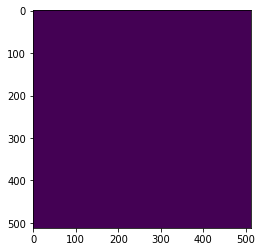

In [60]:
plt.imshow(np.squeeze(model.predict(tf.expand_dims(train_df2[0], 0))))

In [51]:
def UNet2(n_classes=1, IMG_HEIGHT=4536, IMG_WIDTH=4704, IMG_CHANNELS=3):
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Encoder
    c1 = tf.keras.layers.Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.2)(c1)  
    c1 = tf.keras.layers.Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
    c2 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.2)(c2)  
    c2 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
     
    c3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
     
    c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
     
    # Transfer Block
    c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.2)(c8)  
    c8 = tf.keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = tf.keras.layers.Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.2)(c9)  
    c9 = tf.keras.layers.Conv2D(4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = tf.squeeze(tf.keras.layers.Conv2D(n_classes, (1, 1), activation='softmax')(c9))
     
    model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = UNet2(1, 512, 512)
model.compile(optimizer=tf.keras.optimizers.Adam(0.00001),
              loss=dice_coef,)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_38 (Conv2D)             (None, 512, 512, 4)  112         ['input_7[0][0]']                
                                                                                                  
 dropout_18 (Dropout)           (None, 512, 512, 4)  0           ['conv2d_38[0][0]']              
                                                                                                  
 conv2d_39 (Conv2D)             (None, 512, 512, 4)  148         ['dropout_18[0][0]']       

In [57]:
model.fit(train_df2, train_mask2, validation_data=(test_df2, test_mask2), epochs=10, batch_size=2, class_weight= {0:100, 1:1})

Epoch 1/10
3/3 [==============================] - 0s 64ms/step - loss: 0.1007 - val_loss: 0.1401
Epoch 2/10
3/3 [==============================] - 0s 49ms/step - loss: 0.1000 - val_loss: 0.1401
Epoch 3/10
3/3 [==============================] - 0s 53ms/step - loss: 0.1010 - val_loss: 0.1401
Epoch 4/10
3/3 [==============================] - 0s 51ms/step - loss: 0.1009 - val_loss: 0.1401
Epoch 5/10
3/3 [==============================] - 0s 58ms/step - loss: 0.1005 - val_loss: 0.1401
Epoch 6/10
3/3 [==============================] - 0s 44ms/step - loss: 0.1007 - val_loss: 0.1401
Epoch 7/10
3/3 [==============================] - 0s 51ms/step - loss: 0.1001 - val_loss: 0.1401
Epoch 8/10
3/3 [==============================] - 0s 51ms/step - loss: 0.1009 - val_loss: 0.1401
Epoch 9/10
3/3 [==============================] - 0s 46ms/step - loss: 0.1005 - val_loss: 0.1401
Epoch 10/10
3/3 [==============================] - 0s 49ms/step - loss: 0.1005 - val_loss: 0.1401


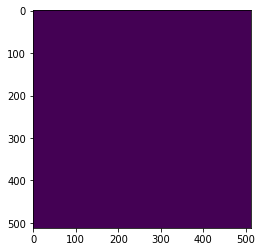

In [54]:
plt.imshow(np.squeeze(model.predict(tf.expand_dims(train_df2[0], 0))))